<h2> Блок: DS-ADD-5. Uplift-моделирование    
<h2> Проект: Подбор оптимального алгоритма для оценки аплифт-эффекта от рекламных предложений.  
<h2> Выполнил: Новиков Павел  
<h2> Группа: DSPR - 100

# Задача

Подобрать оптимальный алгоритм для оценки аплифт-эффекта от рекламных предложений.   
Наш клиент — французское рекламное агентство criteo.   
Оно предоставило нам данные о показах рекламы и отклике пользователей на рекламные предложения.   
Нужно подобрать модель для показа рекламных предложений пользователям.

# Данные


>@inproceedings {Diemert2018,
author = {{Diemert Eustache, Betlei Artem} and Renaudin, Christophe and Massih-Reza, Amini},  
title_name={A Large Scale Benchmark for Uplift Modeling},  
publisher = {ACM},  
booktitle = {Proceedings of the AdKDD and TargetAd Workshop, KDD, London,United Kingdom, August, 20, 2018},  
year = {2018}
}

## Описание данных
Этот набор данных создан путем объединения данных, полученных в результате нескольких тестов на инкрементальность, особой процедуры рандомизированного исследования, при которой случайная часть населения не становится объектом таргетированной рекламы.
Инкрементальность показывает, сколько в действительности новых пользователей (продаж, дохода) было получено.  
Он состоит из 25 миллионов строк, каждая из которых представляет пользователя с 11 признаками, индикатором рекламного воздействия(treatment) и двумя метками (переход(visit) и конверсия(conversions)).  

<h2> Поля </h2>

- f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11 : значения признаков   
- treatment : группа по типу целевого влияния (1 = подвергся целевому влиянию, 0 = контрольная)
- conversion : признак конверсии
- visit: переход или физическое посещение пользователем рекламируемой площадки.
- exposure: группа, для которой изучают воздействие в контексте оценки uplift эффекта.


In [ ]:
! pip install causalml scikit-uplift hyperopt -q

In [ ]:
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.linear_model import LogisticRegression, LinearRegression

# Импортируем S- и T- learner`ы  (SoloModel и TwoModels) из библиотеки scikit-uplift (sklift)
from sklift.models import SoloModel, TwoModels

# Импортируем S- и T-learner`ы (BaseSClassifier и BaseTClassifier) из библиотеки CausalML
from causalml.inference.meta import BaseSClassifier, BaseTClassifier

# Импортируем X- и R-learner`ы (BaseXClassifier и BaseRClassifier) из библиотеки CausalML
from causalml.inference.meta import BaseXClassifier, BaseRClassifier

# библиотеки для uplift-задач классификации - одно Uplift-дерево и случайный лес
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

import hyperopt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

In [ ]:
#В колабе импортируем все необходимые библиотеки
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "1tAbPWF2GJfP05y3Ugjie_SLTtCHtFb49"})
# https://drive.google.com/file/d/1tAbPWF2GJfP05y3Ugjie_SLTtCHtFb49/view?usp=sharing
download.GetContentFile("data.csv.gz")

In [ ]:
# Прочитаем файл с данными
df_1 = pd.read_csv("data.csv.gz")

In [ ]:
# Определим колонки с факторами, тритментом и таргетом
feature_cols = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']
target_col = 'conversion'
treatment_col = 'treatment'

<h2> Disclaimer: </h2>    

В связи с тех. ограничениями моего ПК и санкционной политикой Google, не позволяющей оплатить и воспользоваться дополнительными возможностями Colab:   
1.Анализ будем проводить на 30% выборке из исходной базы данных с сохранённым соотношением целевых признаков.   
2.Гиперпараметры будем подбирать только на простейших моделях и с небольшим разбросом возможных значений.  
3.Во время работы функции оптимизации гиперпараметров придется  отказаться от кросс-валидации в пользу простого расчета метрики на тестовой выборке.


In [ ]:
#разбиваем исходную выборку в соотношении 70/30
df_2, df = train_test_split(df_1,
                            stratify=df_1[[treatment_col, target_col]],
                            test_size=0.3,
                            random_state=42)
# удалим лишние данные и очистим сборщик мусора для высвобождения памяти
del [df_1, df_2]
gc.collect()

38604

## Корреляционная матрица

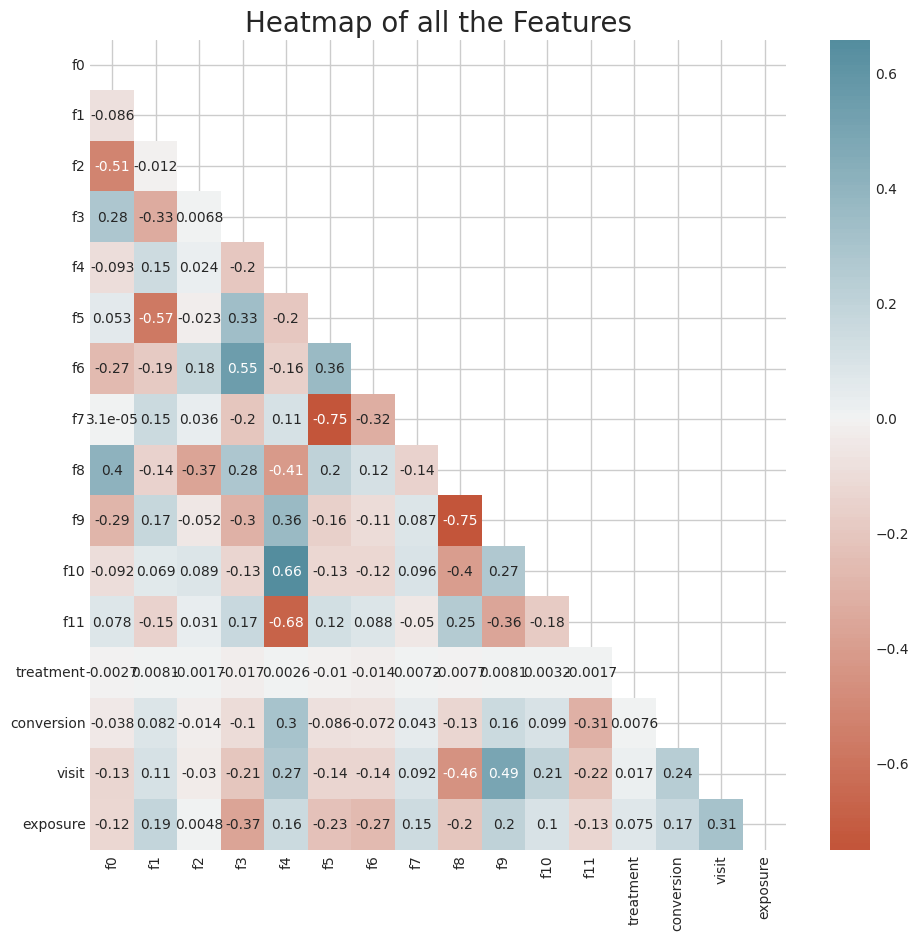

In [ ]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (10,10))

# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype= bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0);
plt.title("Heatmap of all the Features", fontsize = 20);
plt.yticks(rotation=0);

In [ ]:
# удалим промежуточую переменную и очистим сборщик мусора для высвобождения памяти
del [mask]
gc.collect()

14939

Удалим признаки с сильной корреляцией и два дополнительных признака 'visit' и 'exposure', которые не нужны в данном исследовании.

In [ ]:
df.drop(['f5','f8', 'visit', 'exposure'], axis= 1 , inplace= True )

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4193878 entries, 10905729 to 7551430
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f6          float64
 6   f7          float64
 7   f9          float64
 8   f10         float64
 9   f11         float64
 10  treatment   int64  
 11  conversion  int64  
dtypes: float64(10), int64(2)
memory usage: 416.0 MB


#EDA

Удалять дубликаты считаю неразумным, т.к. речь идет о наблюдениях над реакцией респодентов на рекламное воздействие.   
В классическом маркетинге считается нормальной реакция на "несколько" касаний, т.е. перед необходимой реакцией человек должен несколько раз увидеть или нанести визит и удалив данные об одинаковых нереакциях мы удалим эту значимую информацию.
Поэтому предлагаю добавить новый признак о количестве одинаковых реакций.   
По сути тоже, но расчет алгоритма должен пройти легче.

In [ ]:
df = df.groupby (df.columns.tolist(), as_index= False ).size ()
df['size'].value_counts()

1    3774006
2     177506
3      18616
4       1962
5        211
6         17
7          1
Name: size, dtype: int64

In [ ]:
feature_cols = ['f0', 'f1', 'f2', 'f3', 'f4', 'f6', 'f7', 'f9', 'f10', 'f11', 'size']

## Нормализация и стандартизация

In [ ]:
df.describe()

,f0,f1,f2,f3,f4,f6,f7,f9,f10,f11,treatment,conversion,size
count,3.972319e+06,3.972319e+06,3.972319e+06,3.972319e+06,3.972319e+06,3.972319e+06,3.972319e+06,3.972319e+06,3.972319e+06,3.972319e+06,3.972319e+06,3.972319e+06,3.972319e+06
mean,1.967294e+01,1.007054e+01,8.443314e+00,4.152809e+00,1.034216e+01,-4.329137e+00,5.116212e+00,1.617133e+01,5.335187e+00,-1.710912e-01,8.435282e-01,3.079310e-03,1.055776e+00
std,5.345468e+00,1.074355e-01,2.968575e-01,1.366459e+00,3.534134e-01,4.626433e+00,1.235441e+00,7.177947e+00,1.725334e-01,2.348359e-02,3.633021e-01,5.540603e-02,2.563820e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-7.700578e+00,1.028053e+01,-3.015987e+01,4.833815e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,-7.011752e+00,4.833815e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,1.000000e+00
50%,2.192062e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,-3.282109e+00,4.833815e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,1.000000e+00
75%,2.446732e+01,1.005965e+01,8.709417e+00,4.679882e+00,1.028053e+01,2.944427e-01,4.833815e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,1.000000e+00
max,2.674526e+01,1.564063e+01,9.051962e+00,4.679882e+00,2.026147e+01,2.944427e-01,1.199840e+01,7.034982e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,7.000000e+00


## Визуализируем распределения признаков

  0%|          | 0/5 [00:00<?, ?it/s]

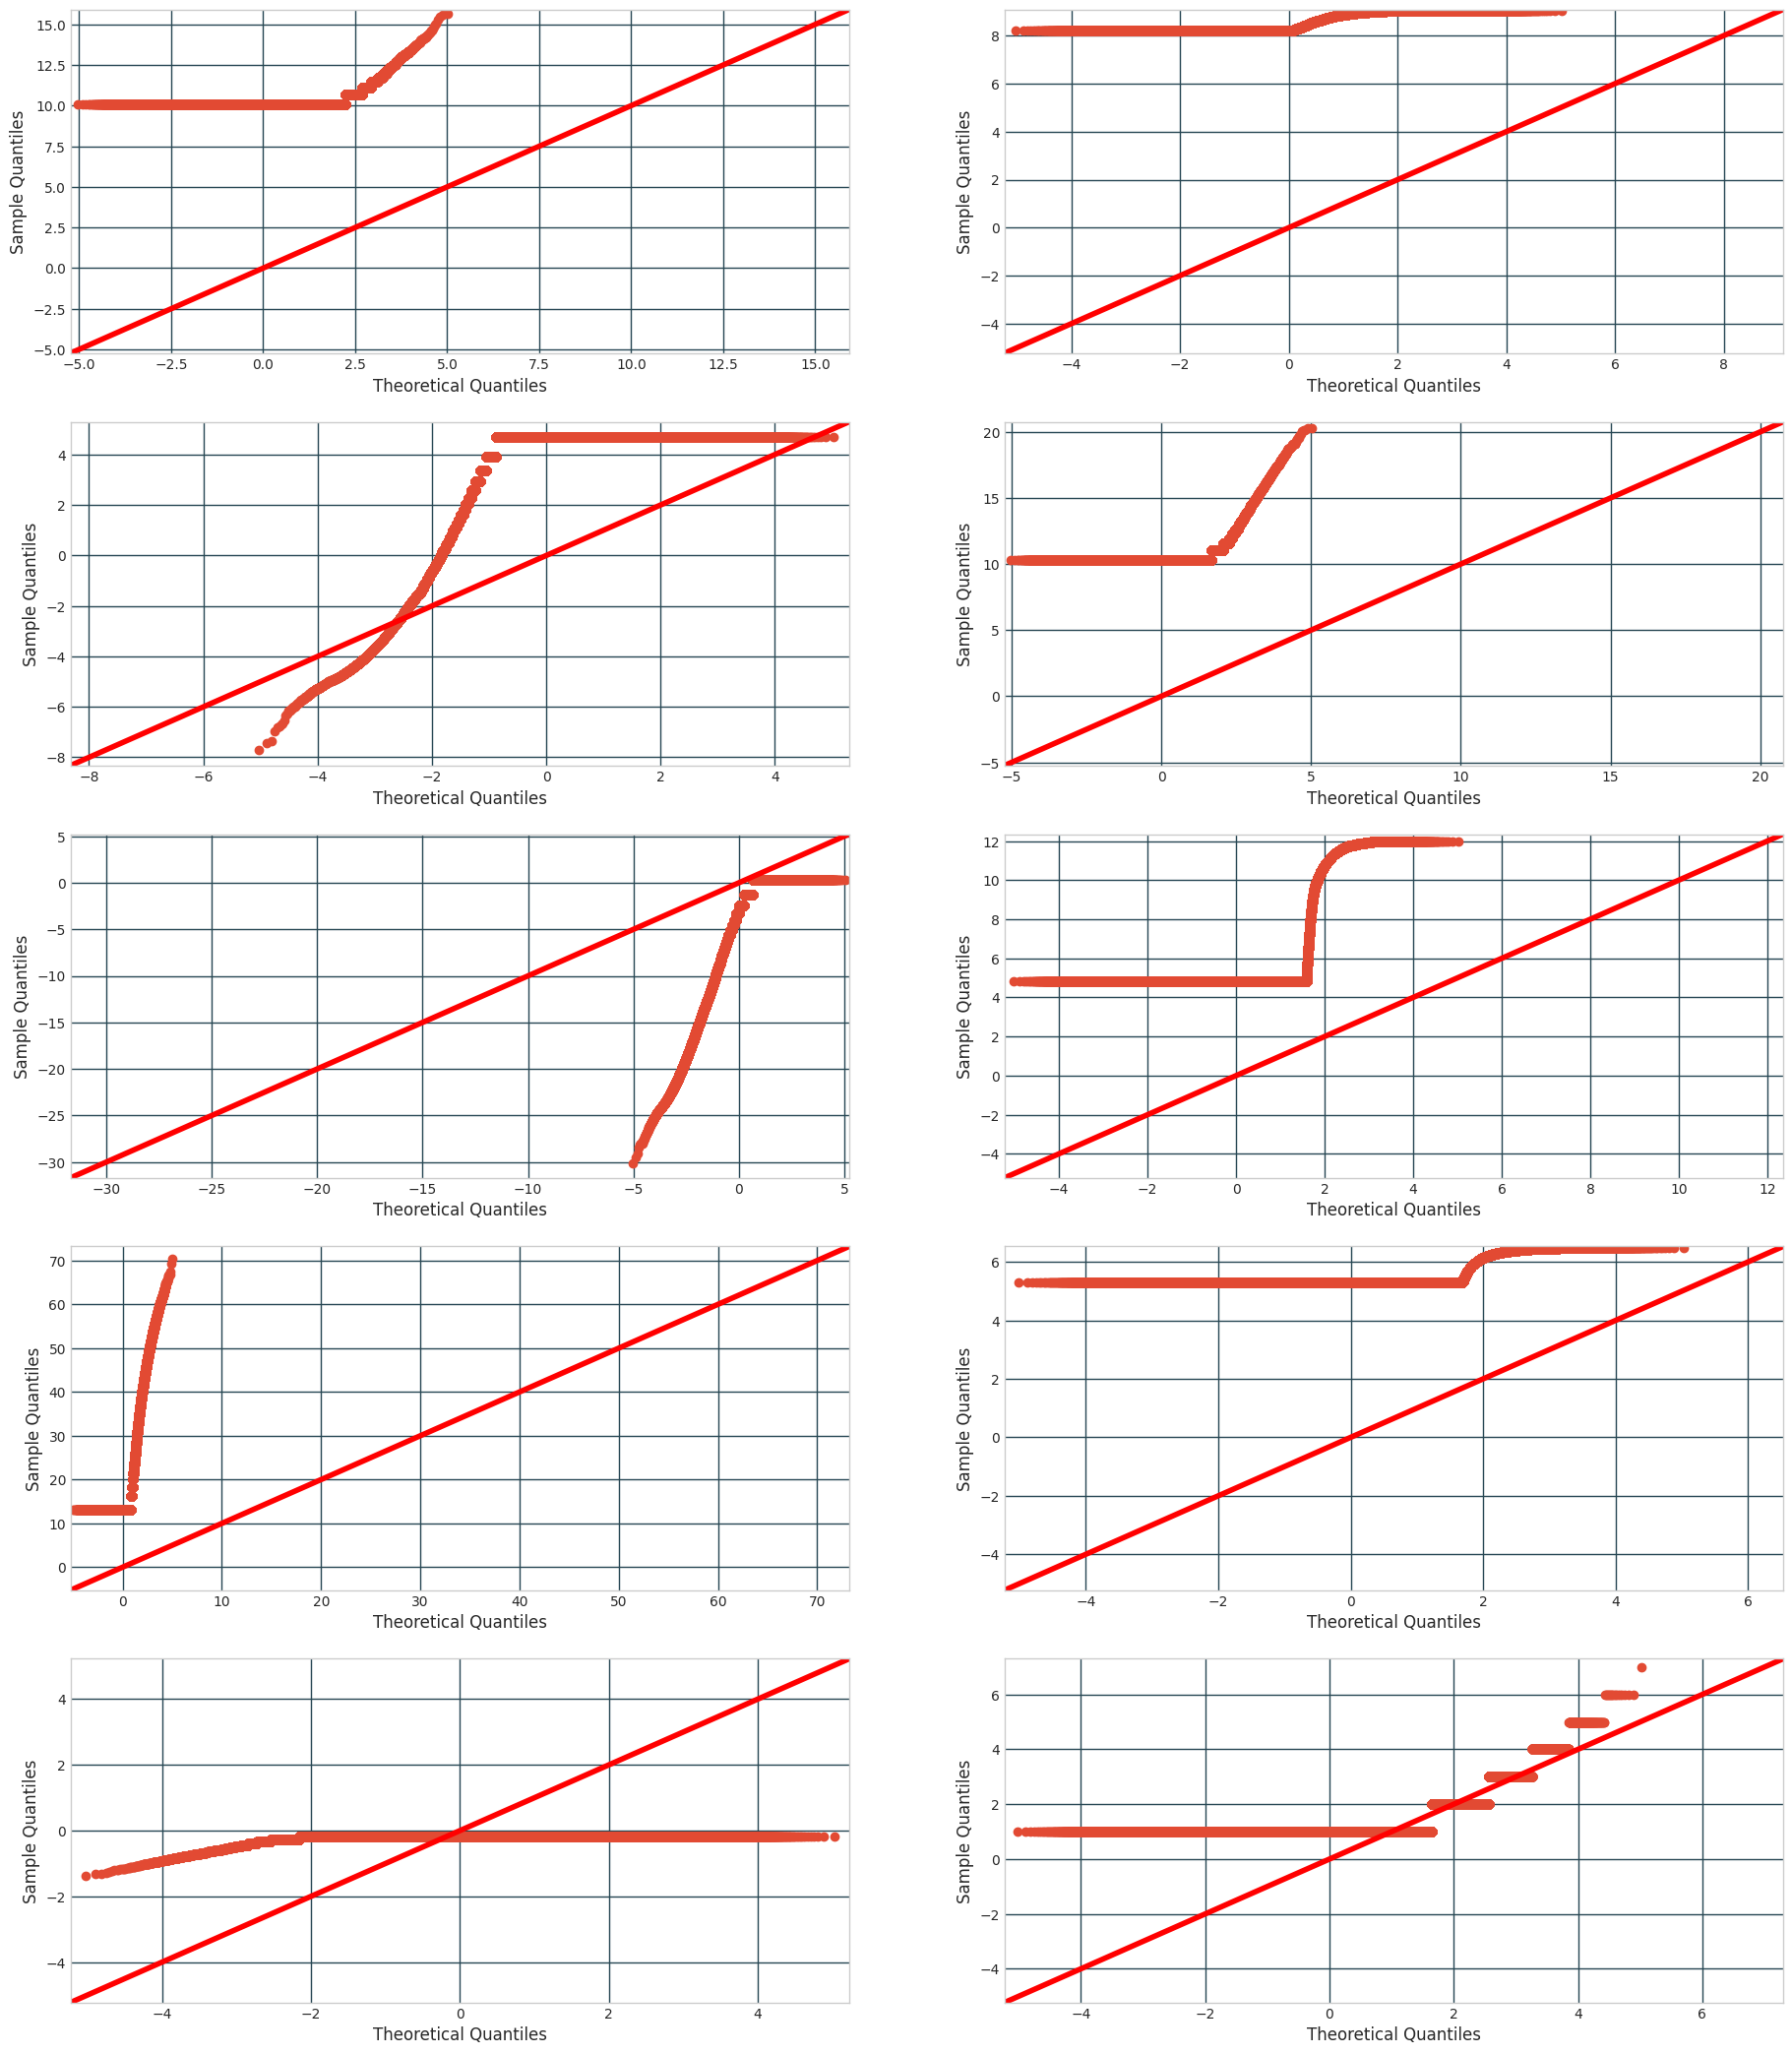

In [ ]:
from tqdm.notebook import tqdm
from statsmodels.graphics.gofplots import qqplot
rows, cols = 5, 2
f, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 25))
f.set_facecolor("#fff")
n_feat = 1
for row in tqdm(range(rows)):
    for col in range(cols):
        try:
            col_name = feature_cols[n_feat]
            qqplot(df[f'{col_name}'], ax=axs[row, col], line='45')
            f.title = f'{col_name}'
            axs[row, col].grid(color="#264653", alpha=1, axis="both")
        except IndexError: # hide last empty graphs
            axs[row, col].set_visible(False)
        n_feat += 1

f.show()

  0%|          | 0/5 [00:00<?, ?it/s]

34790

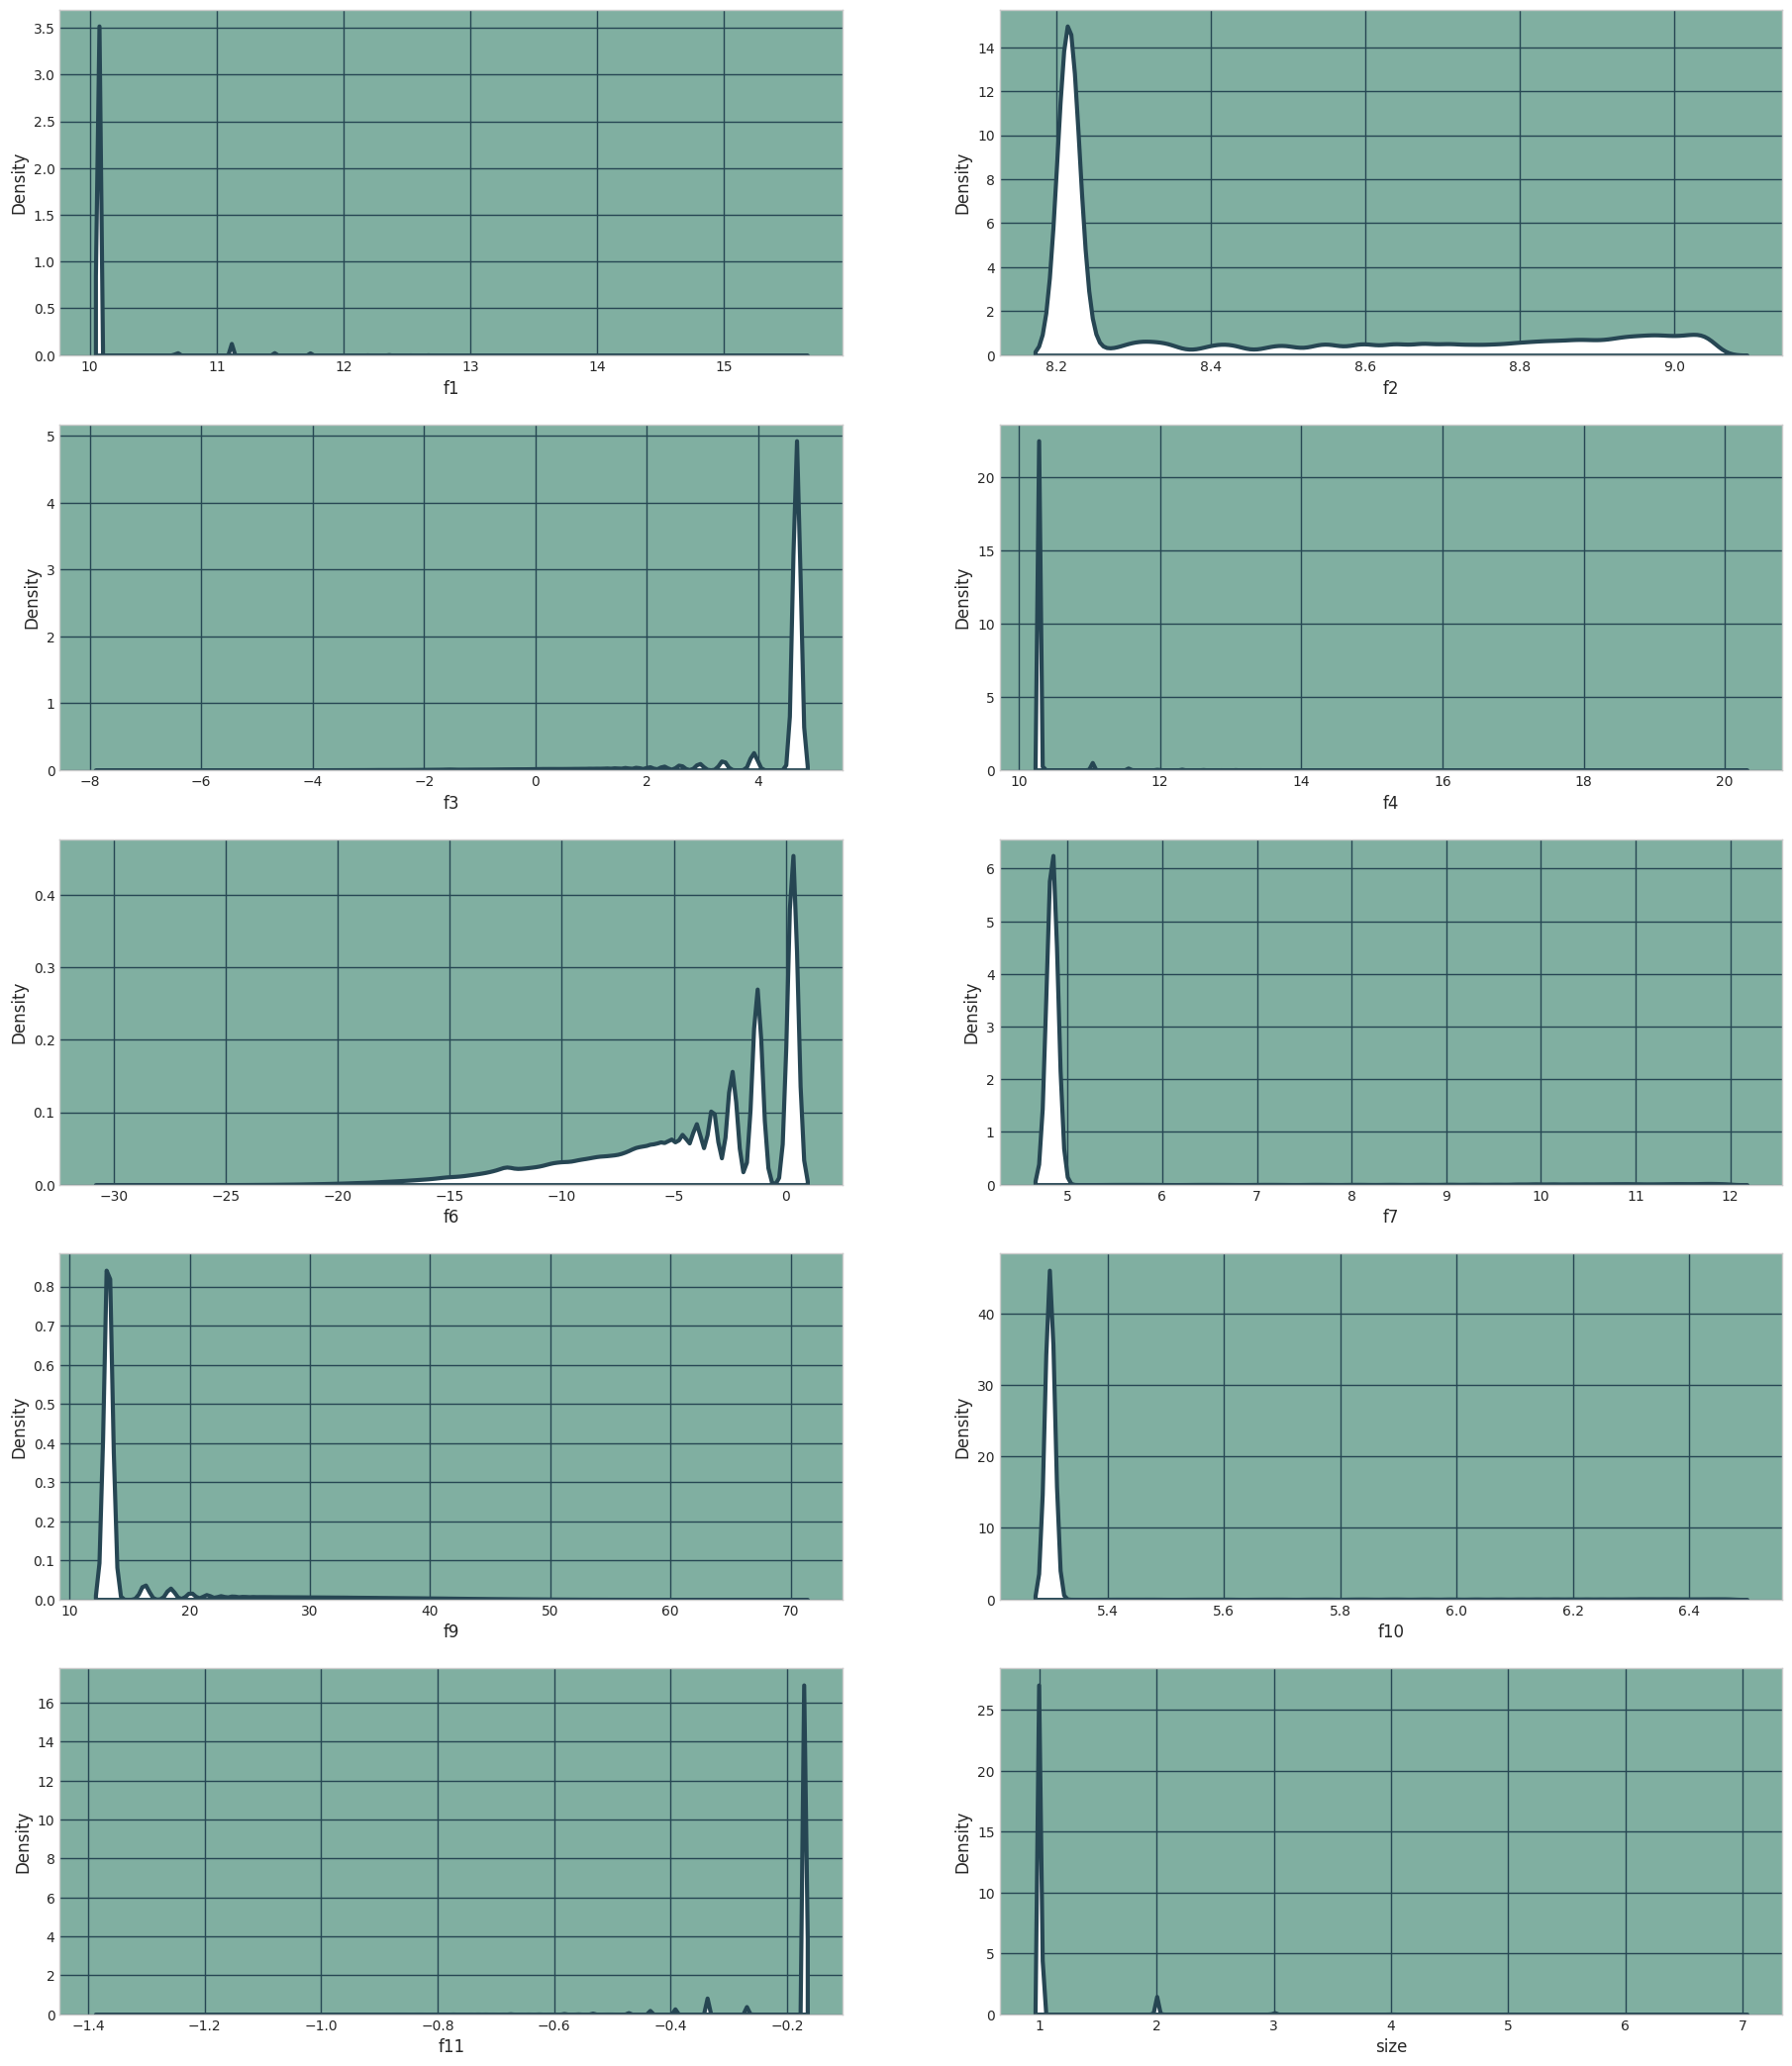

In [ ]:
# анализ распределений kdeplots
rows, cols = 5, 2
f, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 25))
f.set_facecolor("#fff")
n_feat = 1
for row in tqdm(range(rows)):
    for col in range(cols):
        try:
            col_name = feature_cols[n_feat]
            sns.kdeplot(x=f'{col_name}', fill=True, alpha=1, linewidth=3,
                        edgecolor="#264653", data=df, ax=axs[row, col], color='w')
            axs[row, col].patch.set_facecolor("#619b8a")
            axs[row, col].patch.set_alpha(0.8)
            axs[row, col].grid(color="#264653", alpha=1, axis="both")
        except IndexError: # hide last empty graphs
            axs[row, col].set_visible(False)
        n_feat += 1

f.show()
del [f]
gc.collect()

Распределения ненормальны.
Выбросы присутствуют, но непонятно, что с ними делать, т.к. речь идет о наблюдениях за репрезентативной выборкой, массовой рекламе и возможно то, что мы примем за выброс будет означать важную группу для исследования.   

---


Поэтому для нормализации данных применим RobustScaler() устойчивый к выбросам и далее стандартизируем.

In [ ]:
# подготовим пайплайн для нормализации и стандартизации
pipeline_std = Pipeline([('rs',RobustScaler()),('ss', StandardScaler())])
# стандартизируем признаки
df_scale = pipeline_std.fit_transform(df[feature_cols])
# заменим исходные данные шкалированными
df1 = pd.DataFrame(df_scale, columns = feature_cols)
df = df.loc[:, ('treatment', 'conversion')]
df.reset_index(drop= True , inplace= True)
df = df.join(df1)
# удалим лишние данные
del [df1, df_scale]
gc.collect()
df.head(3)

,treatment,conversion,f0,f1,f2,f3,f4,f6,f7,f9,f10,f11,size
0,1,0,-1.320104,-0.101344,-0.771183,0.385722,-0.174397,0.999383,2.992574,-0.415339,-0.201769,0.10271,-0.217549
1,1,0,-1.320104,-0.101344,-0.771183,0.385722,-0.174397,0.999383,2.993179,-0.415339,-0.201769,0.10271,-0.217549
2,1,0,-1.320104,-0.101344,-0.771183,0.385722,-0.174397,0.999383,2.994239,-0.415339,-0.201769,0.10271,-0.217549


In [ ]:
#вывести нулевые значения
df.isnull().sum()

treatment     0
conversion    0
f0            0
f1            0
f2            0
f3            0
f4            0
f6            0
f7            0
f9            0
f10           0
f11           0
size          0
dtype: int64

In [ ]:
df['treatment'].value_counts(normalize=True)

1    0.843528
0    0.156472
Name: treatment, dtype: float64

In [ ]:
df['conversion'].value_counts(normalize=True)

0    0.996921
1    0.003079
Name: conversion, dtype: float64

Признаки дисбалансированы, необходимо стратифицированное разбиение

## Добавление признака "Target Class"

Для расчета вероятностей реакции на воздействие и остутствие воздействия необходимо добавить признак target_class - класс клиента (вспомогательный признак):

0 - Control Non-Responders(CN)

Это клиенты, которым не было выдвинуто предложение (целевое воздействие) и они ничего не купили ((y=0, c) в наших терминах)

1 - Control Responders(CR)

Это клиенты, совершившие покупку без предложения (целевого воздействия) (y=1, c)

2 - Treatment Non-Responders(CN)

Это клиенты, которым было выдвинуто предложение, но они не совершили покупку (y=0, t)

3 - Treatment Responders(CN)

Это клиенты, которым было выдвинуто предложение (совершено целевое воздействие) и они совершили покупку (y=1, t)

При построении классификатора нас интересует только факт того, совершил ли клиент покупку (класс 1) или нет (класс 0).  
Поэтому целевая переменная при классификации - конверсия.



In [ ]:
def target_class(df, treatment, target):
  '''
    Функция для определения Target Class
  '''
  #CN:
  df['target_class'] = 0
  #CR:
  df.loc[(df[treatment] == 0) & (df[target] != 0),'target_class'] = 1
  #TN:
  df.loc[(df[treatment] != 0) & (df[target] == 0),'target_class'] = 2
  #TR:
  df.loc[(df[treatment] != 0) & (df[target] != 0),'target_class'] = 3
  return df

In [ ]:
df = target_class(df.copy(), 'treatment', 'conversion')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3972319 entries, 0 to 3972318
Data columns (total 14 columns):
 #   Column        Dtype  
---  ------        -----  
 0   treatment     int64  
 1   conversion    int64  
 2   f0            float64
 3   f1            float64
 4   f2            float64
 5   f3            float64
 6   f4            float64
 7   f6            float64
 8   f7            float64
 9   f9            float64
 10  f10           float64
 11  f11           float64
 12  size          float64
 13  target_class  int64  
dtypes: float64(11), int64(3)
memory usage: 424.3 MB


# Построим валидационный датасет

Разделим выборку на 3 части обучающую, тестовую для подбора гиперпараметров и валидационную.


In [ ]:
df_train, df_test = train_test_split(df, stratify=df[[treatment_col, target_col]], test_size=0.3, random_state=42)

#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
df_test, df_valid = train_test_split(df_test, stratify=df_test[[treatment_col, target_col]], test_size=0.5, random_state=42)

print(df_train.shape)
print(df_test.shape)
print(df_valid.shape)

del [df]
gc.collect()

(2780623, 14)
(595848, 14)
(595848, 14)


0

# Qini-curve и qini-score

Создадим функцию для построения qini-curve и расчета qini-score.

In [ ]:
# Возьмем функцию для оценки qini-curve
def qini_df(df, title_name= "train", figsize=(5, 3)):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)

    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)

    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t

    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)

    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)

    # Немного кода для визуализации
    fig = plt.figure(figsize=figsize)
    plt.plot(ranked['n'], ranked['uplift'], color='r', label='Model')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b', label='RandomModel')
    plt.legend()
    # plt.title(f'Qini-curve for {title} samples')
    plt.title('Qini-curve for {} samples'.format(title_name))
    plt.show()
    qini_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    print('Qini score: {:.3f}'.format(qini_score))

In [ ]:
# Возьмем функцию для оценки qini-score
def qini_score(df):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)

    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)

    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t

    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)

    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    qini_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    return qini_score

# S-learner


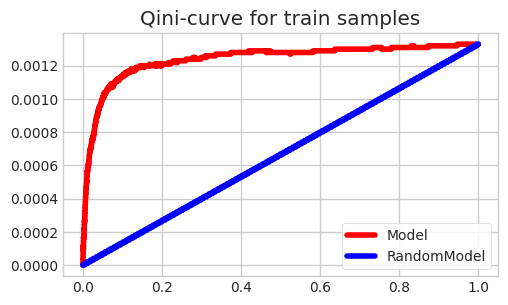

Qini score: 1595.267


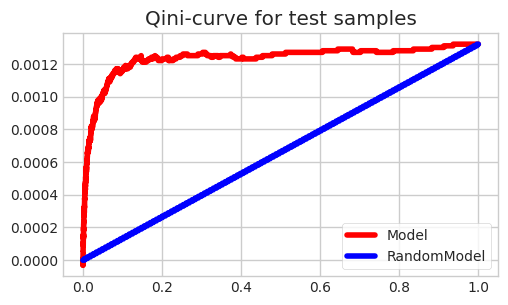

Qini score: 340.674


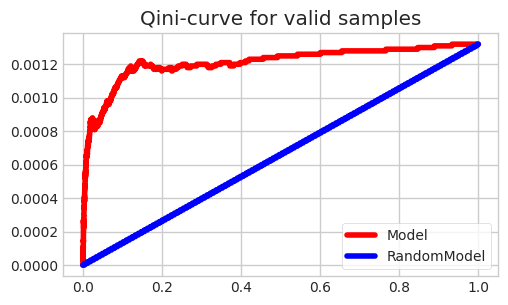

Qini score: 328.102


In [ ]:
# Создаем базовый S-learner
s_learner = SoloModel(
    estimator=LogisticRegression(random_state=42)
)

# Для обучения нам нужны датафрем с факторами, таргет и колонка с фактом воздействия
s_learner = s_learner.fit(
    X=df_train[feature_cols],
    y=df_train[target_col],
    treatment=df_train[treatment_col]
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(df_train[feature_cols])
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на валидационной выборке
uplift_vals = s_learner.predict(df_valid[feature_cols])
df_valid['uplift_score'] = uplift_vals

# Мы получили какие-то значения в рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title_name='train')
qini_df(df_test, title_name='test')
qini_df(df_valid, title_name='valid')

## Подбор гиперпараметров

Проведем оптимизацию гиперпараметров на тестовой выборке

In [ ]:
# зададим пространство поиска гиперпараметров
space={
    'l1_ratio': hp.choice('l1_ratio', np.arange(0.0, 1.0, 0.25)),
    'max_iter': hp.choice('max_iter', np.arange(50.0, 150.0, 50.0))
      }

In [ ]:
trials = Trials() # используется для логирования результатов

In [ ]:
# создадим функцию, которую будет минимизировать алгоритм оптимизации гиперпараметров
def objective(space):
  model = LogisticRegression(**space, solver = 'saga', penalty= 'elasticnet')
  s_learner = SoloModel(
    estimator=model
  )

  # Для обучения нам нужны датафрем с факторами, таргет и колонка с фактом воздействия
  s_learner = s_learner.fit(
    X=df_train[feature_cols],
    y=df_train[target_col],
    treatment=df_train[treatment_col]
  )

  # Сделаем предсказание uplift-эффекта на тестовой выборке
  uplift_vals = s_learner.predict(df_test[feature_cols])
  df_test['uplift_score'] = uplift_vals

  score = qini_score(df_test)
  return  {'loss': -score.mean(), 'params': space, 'status': STATUS_OK}

In [ ]:
# запустим алгоритм оптимизации
best = fmin(objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 10,
            trials = trials,
            rstate=np.random.default_rng(42)
            )

100%|██████████| 10/10 [33:38<00:00, 201.81s/trial, best loss: -340.68281000000013]


In [ ]:
print("Наилучшие значения гиперпараметров {}".format(best))

Наилучшие значения гиперпараметров {'l1_ratio': 0, 'max_iter': 0}


'l1_ratio' = 0.0 соответсвует 'l2' регуляризации, которая установлена в LogisticRegression() по умолчанию.

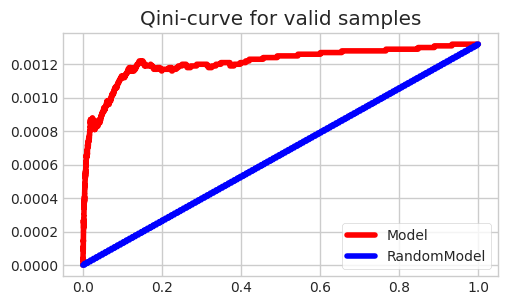

Qini score: 328.091


In [ ]:
# Создаем базовый S-learner на оптимизированных гиперпараметрах
c = int([50.0, 100.0][best['max_iter']])
l1_ratio = int([0.  , 0.25, 0.5 , 0.75][best['l1_ratio']])

s_learner = SoloModel(
    estimator=LogisticRegression(max_iter=c, l1_ratio = l1_ratio, solver = 'saga', penalty = 'elasticnet', random_state=42)
    )

# Для обучения нам нужны датафрем с факторами, таргет и колонка с фактом воздействия
s_learner = s_learner.fit(
    X=df_train[feature_cols],
    y=df_train[target_col],
    treatment=df_train[treatment_col]
)

# Сделаем предсказание uplift-эффекта на валидационной выборке
uplift_vals = s_learner.predict(df_valid[feature_cols])
df_valid['uplift_score'] = uplift_vals

# Мы получили какие-то значения в рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_valid, title_name='valid')

Qini score с оптимизированными гиперпараметрами соответствует с гиперпараметрами LogisticRegression() по умолчанию. Значит оптимальная гиперплоскость построена.

In [ ]:
del [uplift_vals]
gc.collect()

# T-learner


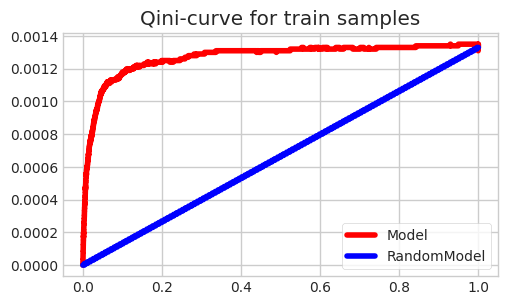

Qini score: 1682.085


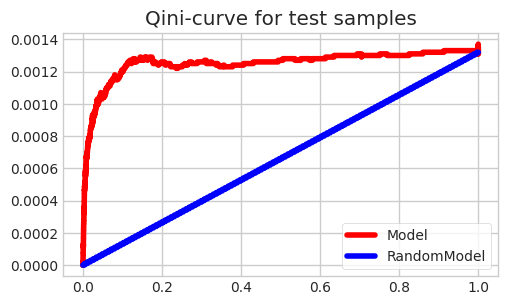

Qini score: 351.780


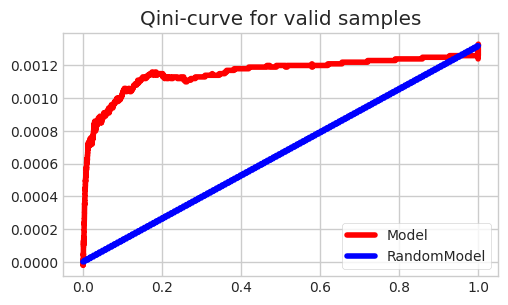

Qini score: 294.798


In [ ]:
# Создадим базовый T-learner
t_learner = TwoModels(
    estimator_trmnt=LogisticRegression(random_state=42),
    estimator_ctrl=LogisticRegression(random_state=42)
)

# Для обучения нам нужны датафрем с факторами, таргет и колонка с фактом воздействия
t_learner = t_learner.fit(
    X=df_train[feature_cols],
    y=df_train[target_col],
    treatment=df_train[treatment_col]
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = t_learner.predict(df_train[feature_cols])
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = t_learner.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на валидационной выборке
uplift_vals = t_learner.predict(df_valid[feature_cols])
df_valid['uplift_score'] = uplift_vals

# Мы получили какие-то значения в рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title_name='train')
qini_df(df_test, title_name='test')
qini_df(df_valid, title_name='valid')

## Подбор гиперпараметров

In [ ]:
# зададим пространство поиска гиперпараметров
space={
    'l1_ratio': hp.choice('l1_ratio', np.arange(0.0, 1.0, 0.25)),
    'max_iter': hp.choice('max_iter', np.arange(50.0, 150.0, 50.0))
      }

In [ ]:
trials = Trials() # используется для логирования результатов

In [ ]:
# создадим функцию, которую будет минимизировать алгоритм оптимизации гиперпараметров
def objective(space):

  t_learner = TwoModels(
    estimator_trmnt=LogisticRegression(**space, solver = 'saga', penalty= 'elasticnet'),
    estimator_ctrl=LogisticRegression()
  )

  # Для обучения нам нужны датафрем с факторами, таргет и колонка с фактом воздействия
  t_learner = t_learner.fit(
    X=df_train[feature_cols],
    y=df_train[target_col],
    treatment=df_train[treatment_col]
  )

  # Сделаем предсказание uplift-эффекта на тестовой выборке
  uplift_vals = t_learner.predict(df_test[feature_cols])
  df_test['uplift_score'] = uplift_vals

  score = qini_score(df_test)
  return  {'loss': -score.mean(), 'params': space, 'status': STATUS_OK}

In [ ]:
# запустим алгоритм оптимизации
best = fmin(objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 10,
            trials = trials,
            rstate=np.random.default_rng(42)
            )

100%|██████████| 10/10 [28:44<00:00, 172.42s/trial, best loss: -352.11073]


In [ ]:
print("Наилучшие значения гиперпараметров {}".format(best))

Наилучшие значения гиперпараметров {'l1_ratio': 3, 'max_iter': 0}


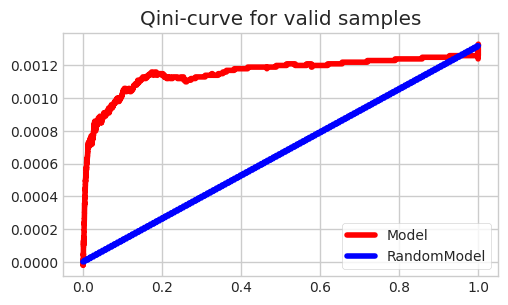

Qini score: 295.058


In [ ]:
# Создаем базовый T-learner
c = int([50.0, 100.0][best['max_iter']])
l1_ratio = int([0.  , 0.25, 0.5 , 0.75][best['l1_ratio']])
model = LogisticRegression(max_iter=c, l1_ratio = l1_ratio, solver = 'saga', penalty = 'elasticnet', random_state=42)
# Создадим базовый T-learner
t_learner = TwoModels(
    estimator_trmnt=model,
    estimator_ctrl=LogisticRegression()
)

# Для обучения нам нужны датафрем с факторами, таргет и колонка с фактом воздействия
t_learner = t_learner.fit(
    X=df_train[feature_cols],
    y=df_train[target_col],
    treatment=df_train[treatment_col]
)

# Сделаем предсказание uplift-эффекта на валидационной выборке
uplift_vals = t_learner.predict(df_valid[feature_cols])
df_valid['uplift_score'] = uplift_vals

# Мы получили какие-то значения в рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_valid, title_name='valid')

Подбор гиперпараметров дал мизерный прирост метрики.

# X-learner


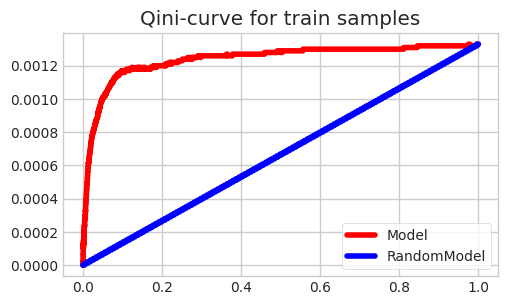

Qini score: 1594.618


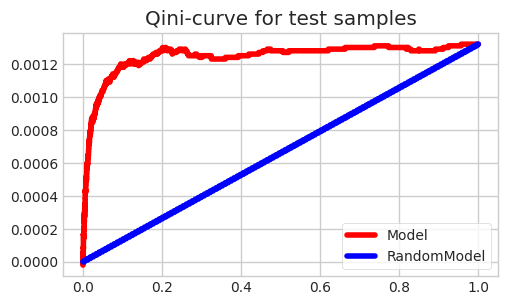

Qini score: 346.916


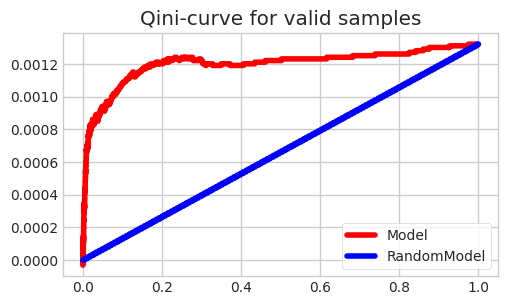

Qini score: 320.604


In [ ]:
# Давайте по данным построим X-learner

# Создадим базовый X-learner
x_learner = BaseXClassifier(
    outcome_learner=LogisticRegression(),
    effect_learner=LinearRegression()
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
x_learner.fit(
    X=df_train[feature_cols],
    treatment=df_train[treatment_col],
    y=df_train[target_col]
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = x_learner.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = x_learner.predict(np.array(df_valid[feature_cols].values.copy()))
df_valid['uplift_score'] = uplift_vals

# Мы получили какие-то значения в рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title_name='train')
qini_df(df_test, title_name='test')
qini_df(df_valid, title_name='valid')

# R-learner

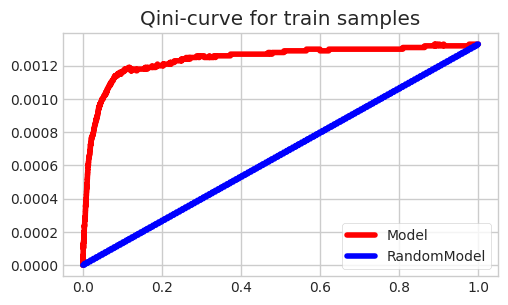

Qini score: 1594.165


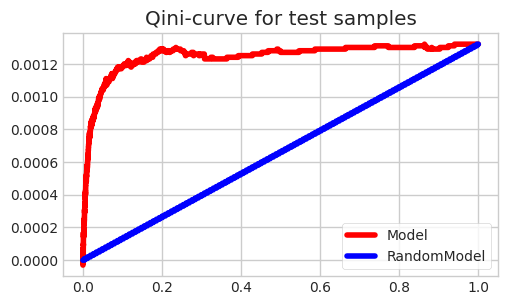

Qini score: 347.781


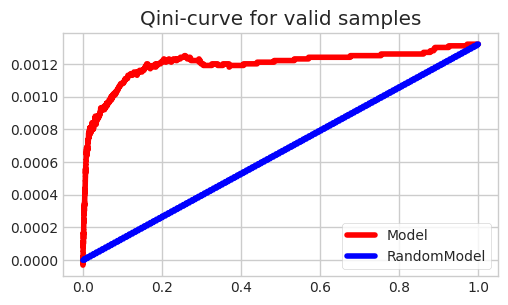

Qini score: 319.674


In [ ]:
# Давайте по данным построим R-learner

# Создадим базовый R-learner
r_learner = BaseRClassifier(
    outcome_learner=LogisticRegression(n_jobs =-1),
    effect_learner=LinearRegression(),
    random_state=42
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
r_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = r_learner.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на валидационной выборке
uplift_vals = r_learner.predict(np.array(df_valid[feature_cols].values.copy()))
df_valid['uplift_score'] = uplift_vals

# Мы получили какие-то значения в рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title_name='train')
qini_df(df_test, title_name='test')
qini_df(df_valid, title_name='valid')

# UpliftRandomForest


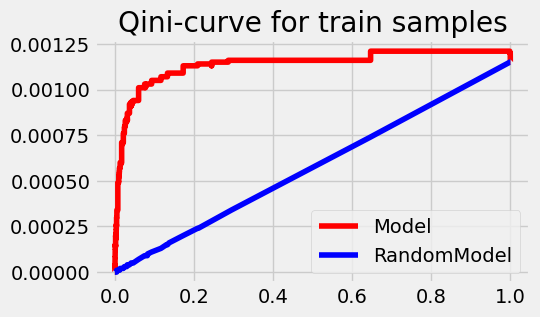

Qini score: 1878.753


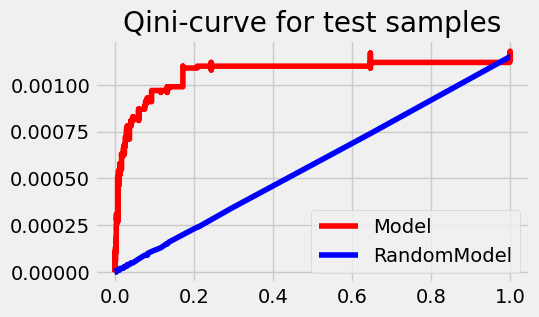

Qini score: 211.163


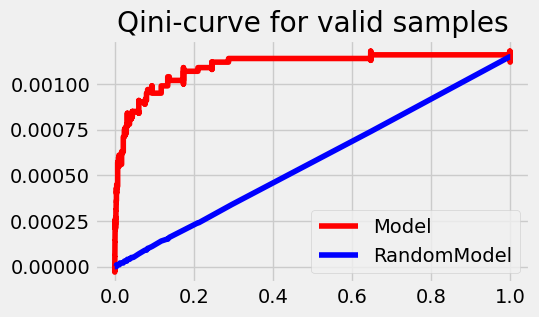

Qini score: 221.186


In [ ]:
# Создаем простое дерево.
uplift_forest = UpliftRandomForestClassifier(
    n_estimators=5, max_depth=5, min_samples_leaf=10,
    min_samples_treatment=10,
    n_reg=10, evaluationFunction='ED',
    control_name='0', random_state=42
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
# Обратите внимание, что для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_forest.fit(
    df_train[feature_cols].values,
    treatment=df_train[treatment_col].apply(str).values,
    y=df_train[target_col].values
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(df_valid[feature_cols].values.copy()))
df_valid['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title_name='train')
qini_df(df_test, title_name='test')
qini_df(df_valid, title_name='valid')

# Результаты

|<h2>  Модель | <h2> Qini-score |
| --------| ---------- |
| <h2> S-learner | <h2> 328.091 |
| <h2> T-learner | <h2> 295.058 |
| <h2> X-learner | <h2> 320.604 |
| <h2> R-learner | <h2> 319.674 |
| <h2> UpliftRandomForest |<h2> 221.186 |

Нашей задачей было подобрать оптимальный алгоритм для оценки аплифт-эффекта от рекламных предложений.

Для этого нужно было подобрать модель для показа рекламных предложений пользователям.

В результате наилучший результат показала модель S-learner c моделью регрессии LogisticRegression() с гиперпараметрами по умолчанию.

